In [1]:
# This notebook is for computing gradients for diffusion data using HCPMMP cortical parcellation matrix and HCP 7TDWI subjects (N=173).

# Includes the following analyses:
#     Connectivity matrix loading/checking
#     Gradients calculation
#     Gradient Variance explained
#     BF gradient weighted Cortical Projection
#     comparsion with BF stereostatic atlas
#     subregion variability

In [2]:
import os
from numpy import load
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
import pandas as pd
import nibabel as nib
from nilearn.plotting import view_img, plot_glass_brain, plot_anat, plot_roi
from brainspace.datasets import load_fsa5
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_parcellation
from brainspace.utils.parcellation import map_to_labels
from neuromaps import images
from nilearn import plotting
import seaborn as sns
from scipy.spatial.distance import cdist
from brainspace.null_models.variogram import SurrogateMaps
from matplotlib.colors import ListedColormap

### Setting the path

In [3]:
# Set this to your git-repo path for running the analyses.
main_path = "/home/ROBARTS/alik/graham/cfmm-bids/Khan/MarmZona_94T/derivatives/marm94T-gradients/marm94T-gradients"
local_path='.'

In [4]:
# Setting other paths
data_path = main_path + "/data/"
results_path = local_path + "/results/Diff_gradients/"
fig_path = local_path + "/results/Diff_gradients/figures/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

### Get the connectivity matrix

In [5]:
# load npz data - you should place your data.npz file in data directory
connmap_L_npz = '/home/ROBARTS/alik/graham/cfmm-bids/Khan/MarmZona_94T/derivatives/subcorticalparc-smk/subcorticalparc_smk/results/diffparc/sub-betty/sub-betty_hemi-L_space-individual_label-ZI_from-MBMv212_connMap.npz'
connmap_R_npz = '/home/ROBARTS/alik/graham/cfmm-bids/Khan/MarmZona_94T/derivatives/subcorticalparc-smk/subcorticalparc_smk/results/diffparc/sub-betty/sub-betty_hemi-R_space-individual_label-ZI_from-MBMv212_connMap.npz'

data_L = load(connmap_L_npz)
data_R = load(connmap_R_npz)


corr_L = data_L['conn']
print(corr_L.shape)


corr_R = data_R['conn']
print(corr_R.shape)

corr = np.concatenate([corr_L,corr_R],axis=0)
corr.shape

nvox_L = corr_L.shape[0]
nvox_R = corr_R.shape[0]

(348, 116)
(300, 116)


In [6]:
# Average correlation matrix
#corr_avg = np.nanmean(correlation,axis=0)
corr += 1
corr[np.isnan(corr)] = 1

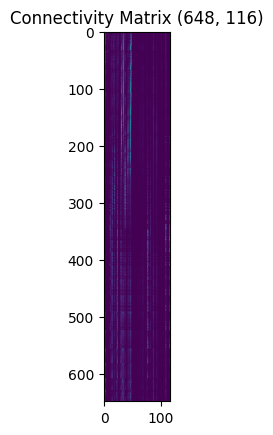

In [7]:
# Plot this matrix.
f, ax = plt.subplots(1,1,dpi=100)
ax.imshow(corr)
ax.set_title('Connectivity Matrix {}'.format(corr.shape))
plt.show()

### Calculate Gradient

In [8]:
n_components=100 # specify gradient components here

In [9]:
from brainspace.gradient import GradientMaps

# Build gradients using diffusion maps and normalized angle and fit to the data.
gm = GradientMaps(n_components=n_components, 
                  kernel='normalized_angle',
                  approach='dm',
                  random_state=0)
print(gm.fit(corr))

GradientMaps(kernel='normalized_angle', n_components=100, random_state=0)


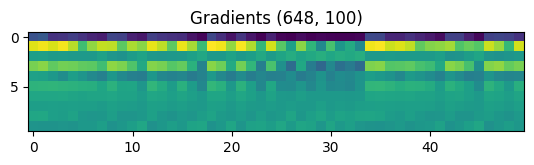

In [10]:
# Plot this gradients (up to 10 component and 50 BF voxel)
f, ax = plt.subplots(1,1,dpi=100)
ax.imshow(gm.gradients_[:50,:10].T)
ax.set_title('Gradients {}'.format(gm.gradients_.shape))
plt.show()

In [11]:
# save the gradient
pd.DataFrame(gm.gradients_).to_csv(results_path + f'Diff_gradients-{n_components}_seed-ZI.csv', index=False)

In [12]:
# save the BF gradients (up to 6 components) as nifti files
seed_L_file = '/home/ROBARTS/alik/graham/cfmm-bids/Khan/MarmZona_94T/derivatives/subcorticalparc-smk/subcorticalparc_smk/results/diffparc/sub-betty/sub-betty_hemi-L_space-individual_res-dwi_label-ZI_from-MBMv212_mask.nii.gz'
seed_R_file = '/home/ROBARTS/alik/graham/cfmm-bids/Khan/MarmZona_94T/derivatives/subcorticalparc-smk/subcorticalparc_smk/results/diffparc/sub-betty/sub-betty_hemi-R_space-individual_res-dwi_label-ZI_from-MBMv212_mask.nii.gz'

seed_header = nib.load(seed_L_file).header
seed_affine = data_L['affine']

mask_L = data_L['mask']
mask_R = data_R['mask']


for gradi in range(6):

    grad_vol = np.zeros(mask_L.shape)
    grad_vol[mask_L > 0] = gm.gradients_[:nvox_L,gradi]
    grad_vol[mask_R > 0] = gm.gradients_[nvox_L:,gradi]
    
    grad_nib = nib.Nifti1Image(grad_vol,seed_affine,header=seed_header)
    grad_nib.to_filename(results_path + f'Diff_gradient_{gradi+1}.nii.gz')

### Calculate Gradient Variance

/tmp/ipykernel_2860888/4251036695.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[0,1,20,40,60,80,100])


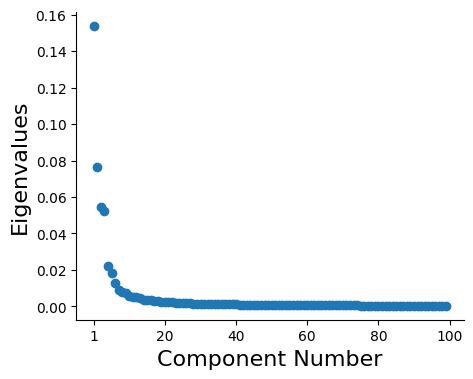

In [13]:
fig, ax = plt.subplots(1, figsize=(5, 4))
ax.scatter(range(gm.lambdas_.size), gm.lambdas_)
ax.set_xticklabels(labels=[0,1,20,40,60,80,100])
#ax.set_xticklabels(labels=[0,1,3,5,7,9,10])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Component Number', fontsize=16)
ax.set_ylabel('Eigenvalues', fontsize=16)
plt.savefig(fig_path + f'Diff_Gradient_eiganvalue_gm-{n_components}.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_2860888/2570041700.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[0,1,20,40,60,80,100])


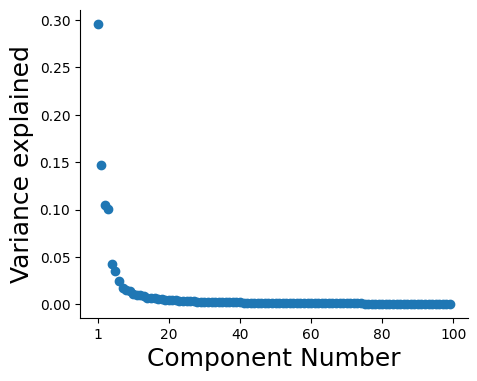

In [14]:
variance = gm.lambdas_ / np.sum(gm.lambdas_)
fig, ax = plt.subplots(1, figsize=(5, 4))
ax.scatter(range(variance.size), variance)
ax.set_xticklabels(labels=[0,1,20,40,60,80,100])
#ax.set_xticklabels(labels=[0,1,3,5,7,9,10])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Component Number', fontsize=18)
ax.set_ylabel('Variance explained', fontsize=18)
plt.savefig(fig_path + f'Diff_Gradient_variance_gm-{n_components}.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# Save the variance explained by each gradient components
pd.DataFrame(variance).to_csv(results_path + f'Diff_gradients_variance_gm-{n_components}.csv', index=False)

/tmp/ipykernel_2860888/1288682825.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[0,1,20,40,60,80,100])


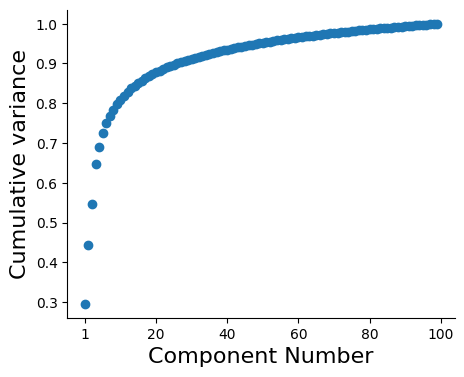

In [16]:
cum_var = np.cumsum(gm.lambdas_) / np.sum(gm.lambdas_)
fig, ax = plt.subplots(1, figsize=(5, 4))
ax.scatter(range(cum_var.size), cum_var)
ax.set_xticklabels(labels=[0,1,20,40,60,80,100])
#ax.set_xticklabels(labels=[0,1,3,5,7,9,10])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Component Number', fontsize=16)
ax.set_ylabel('Cumulative variance', fontsize=16)
plt.savefig(fig_path + f'Diff_Gradient_cumulative-variance_gm-{n_components}.png', dpi=300, bbox_inches='tight')
plt.show()

### Visualize Gradients

In [17]:
# set the colors for gradient visualization
colors = ['seismic','Spectral','bwr','PRGn','coolwarm','BrBG']

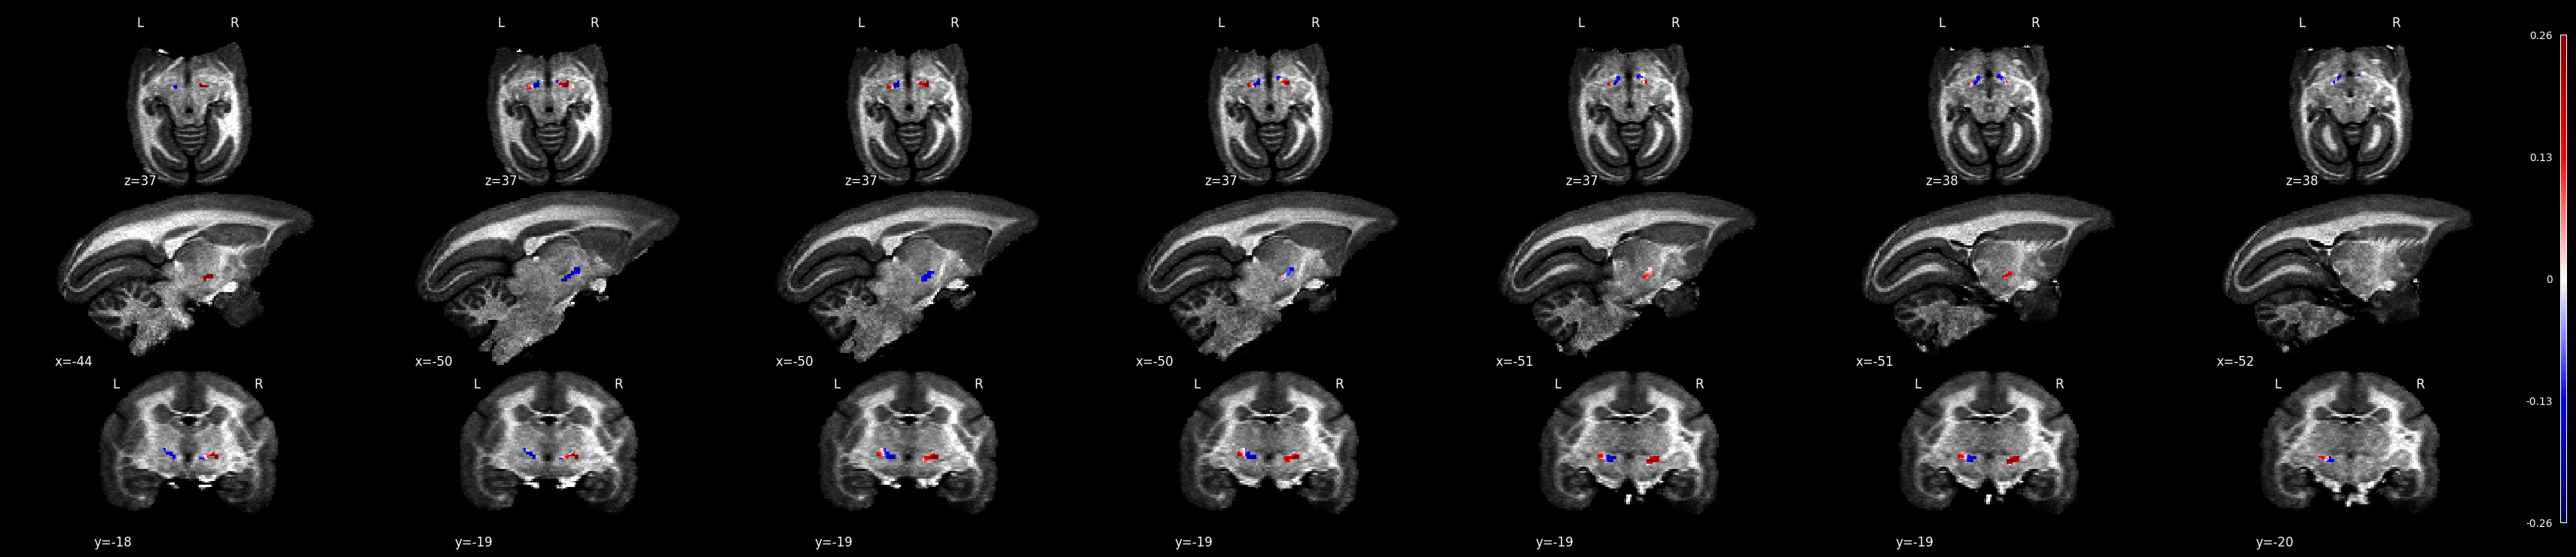

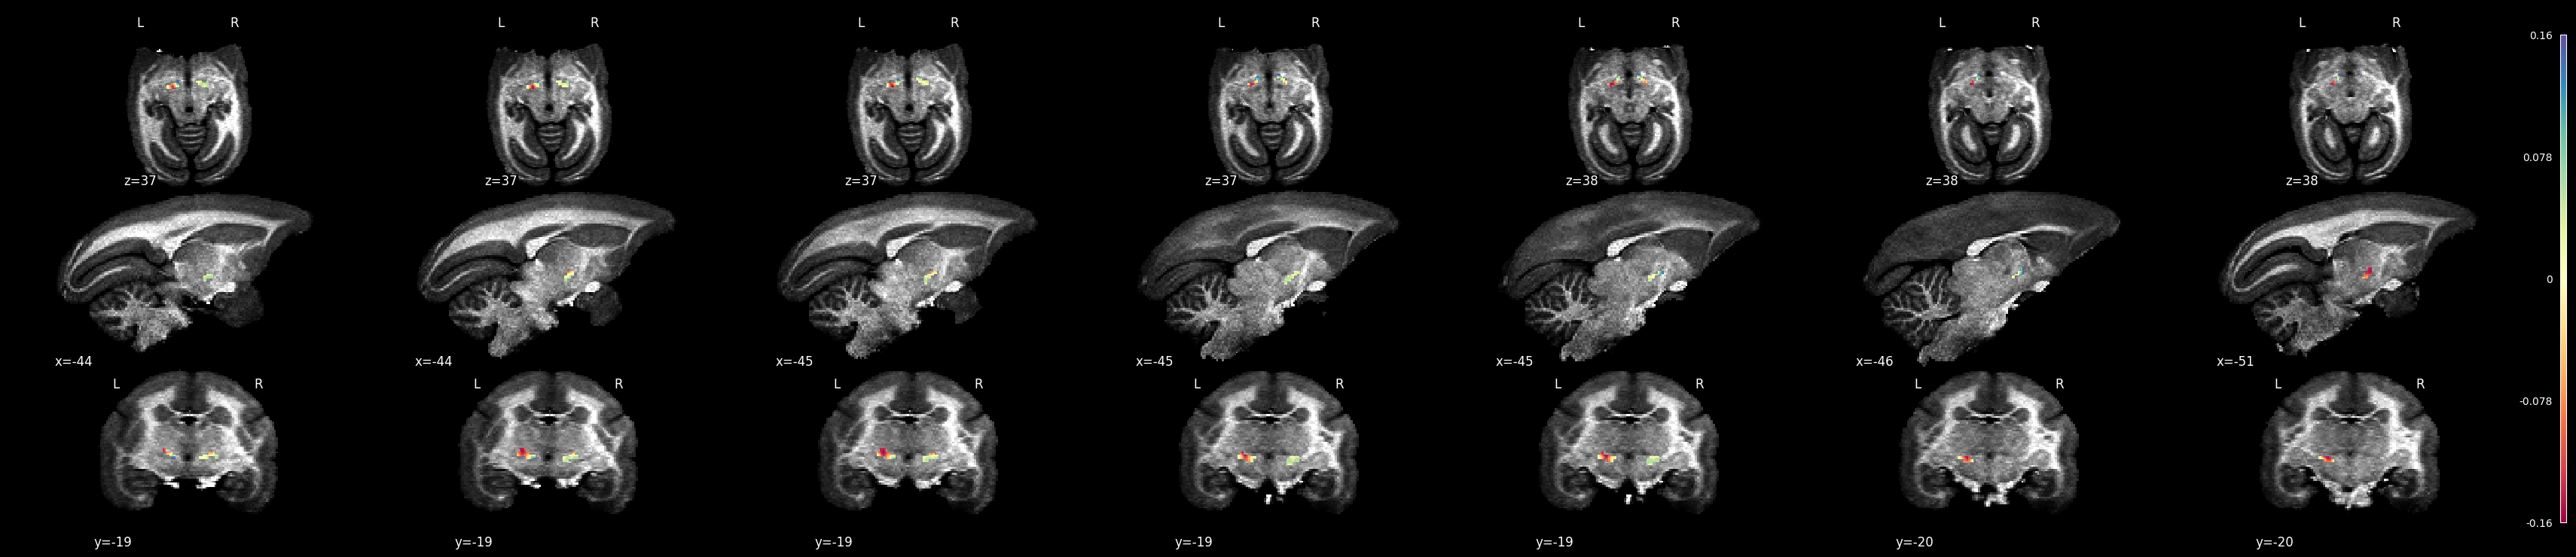

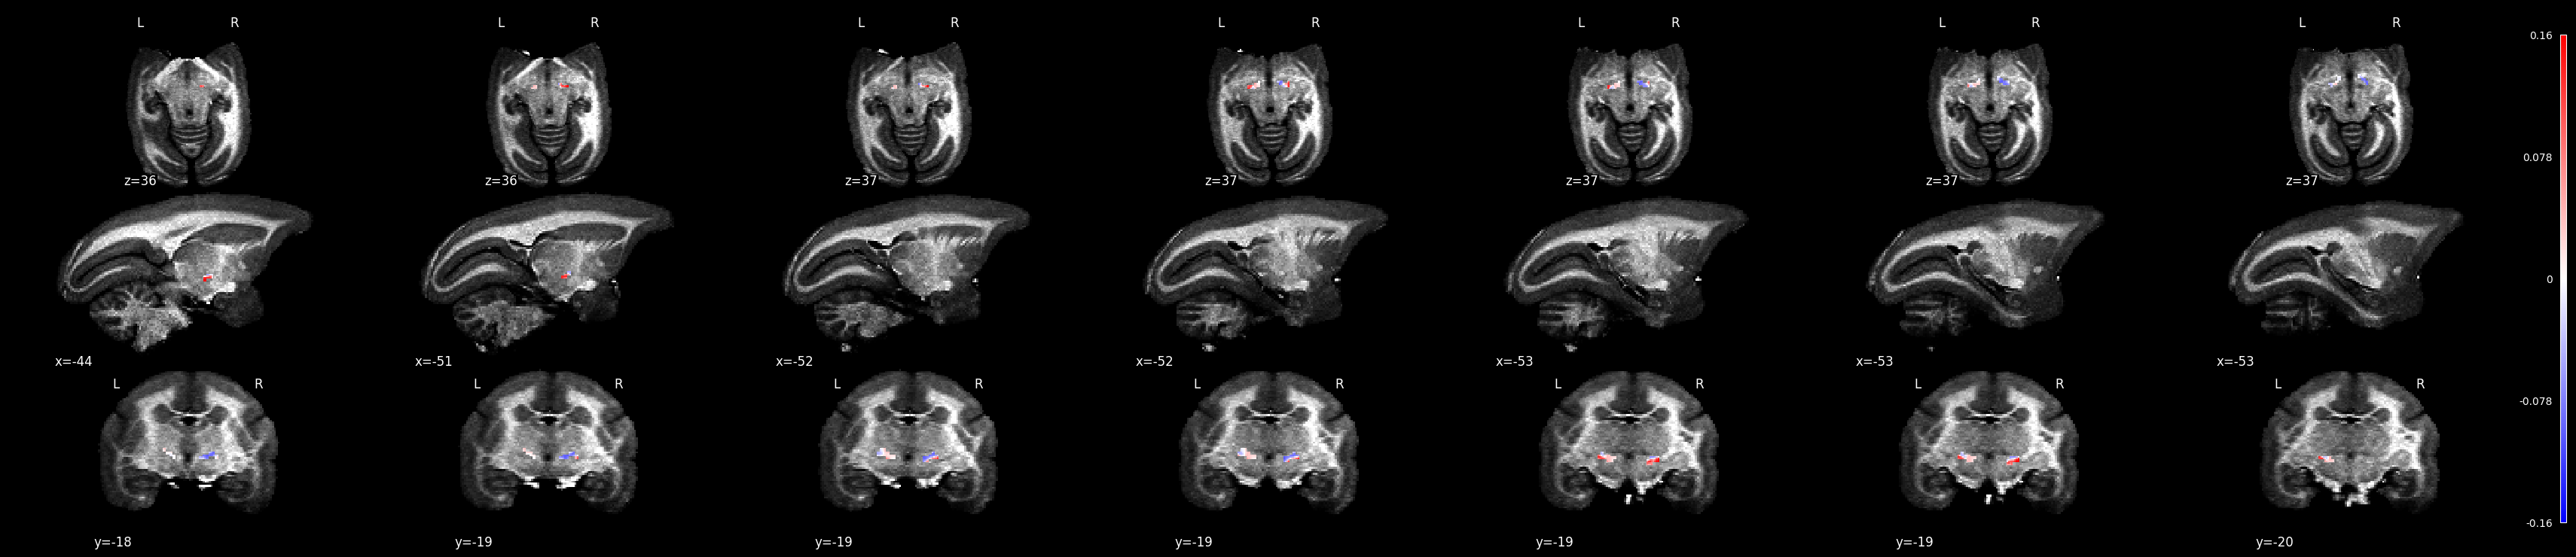

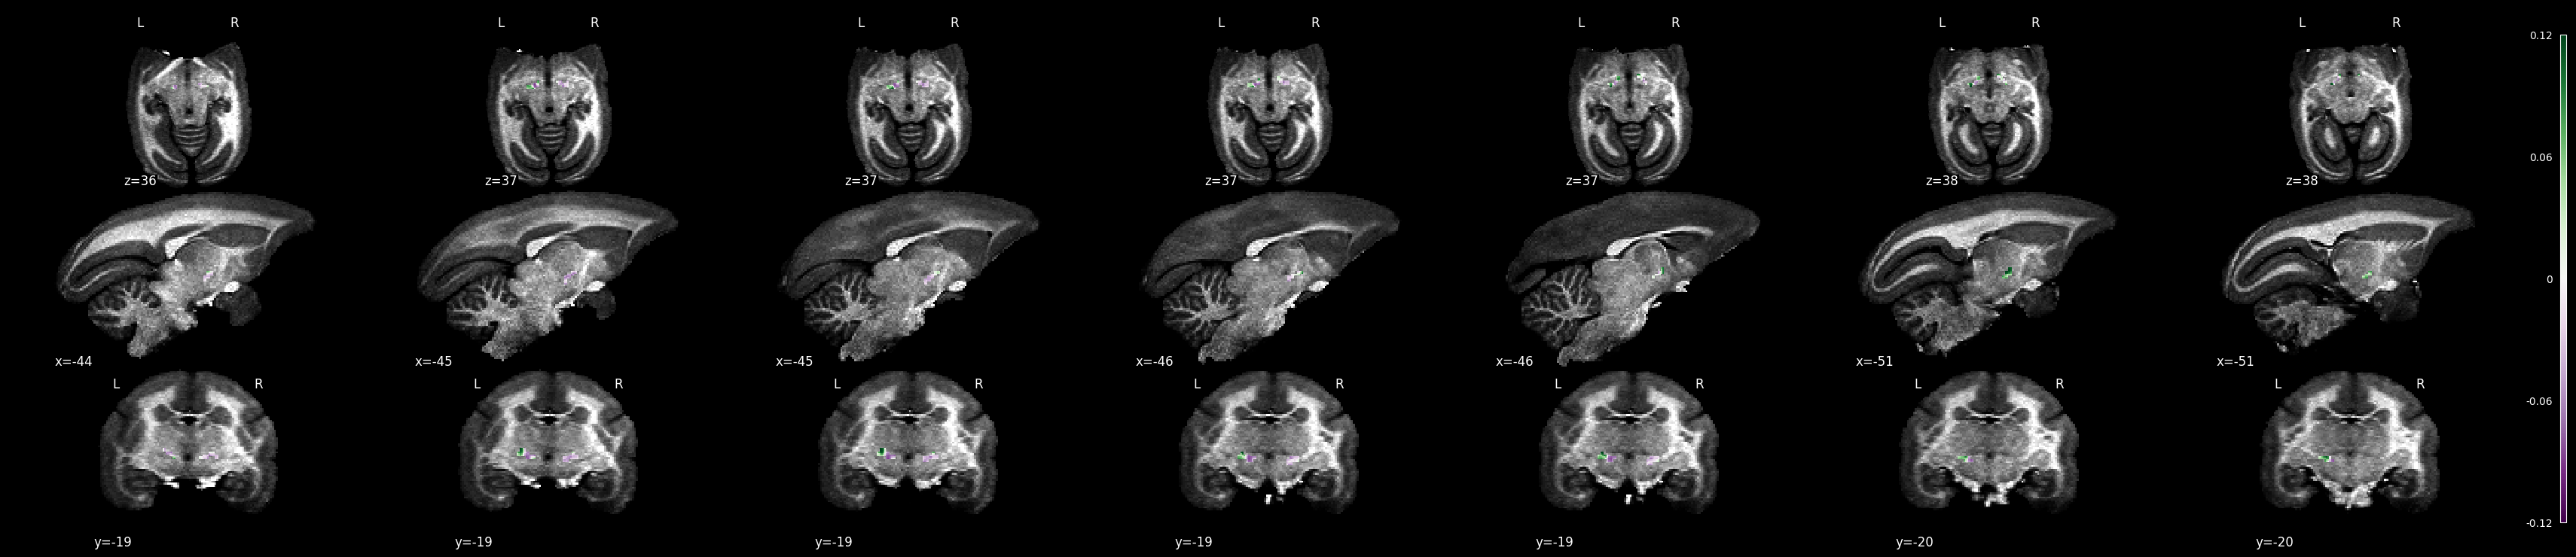

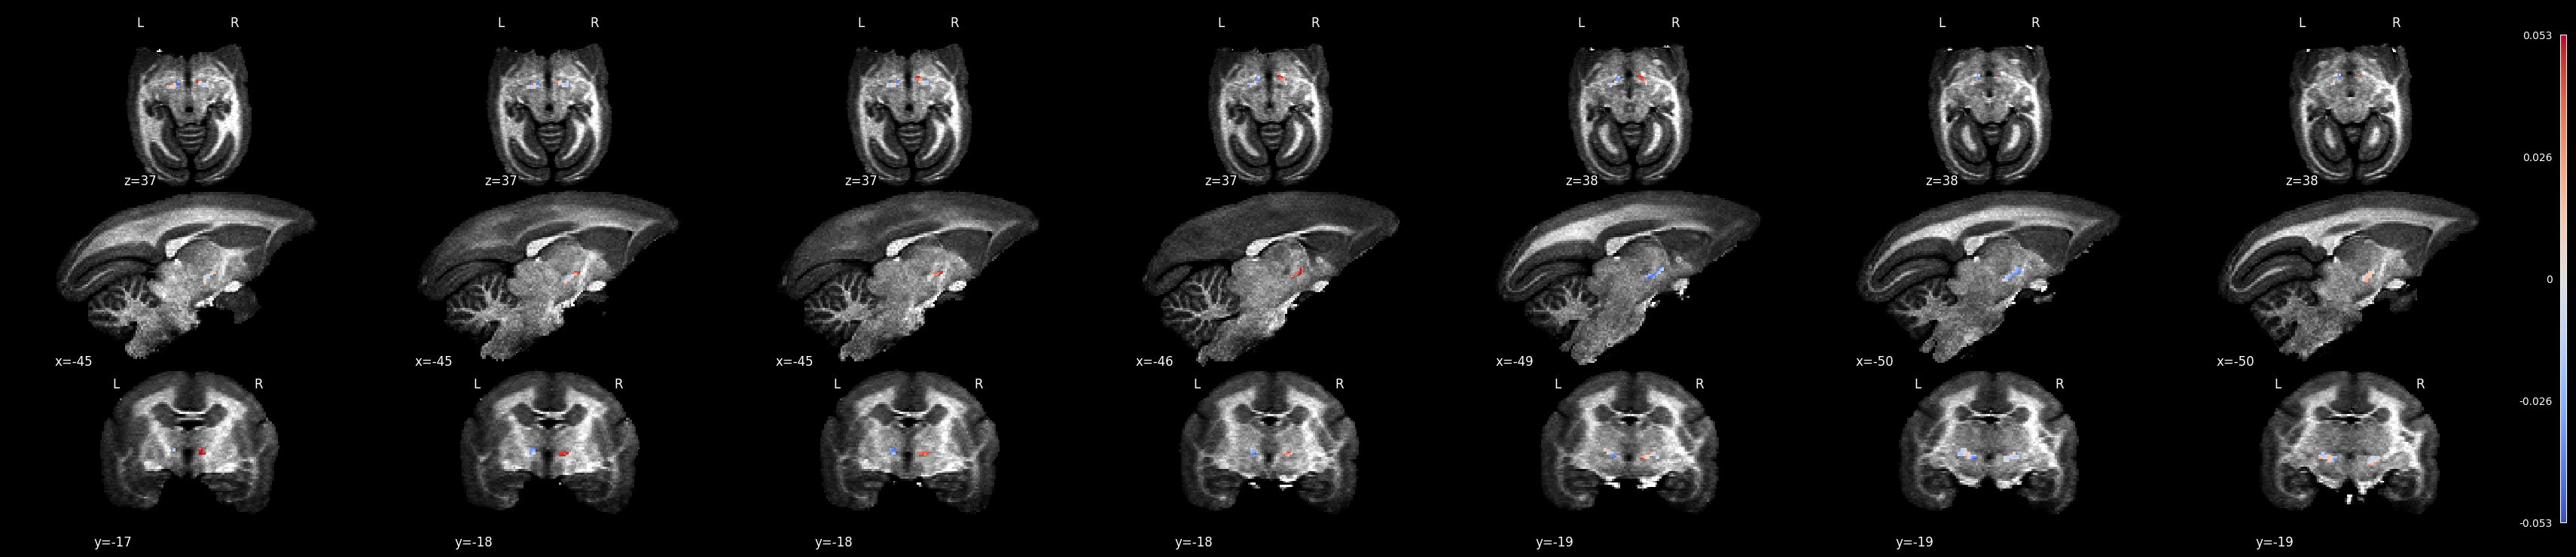

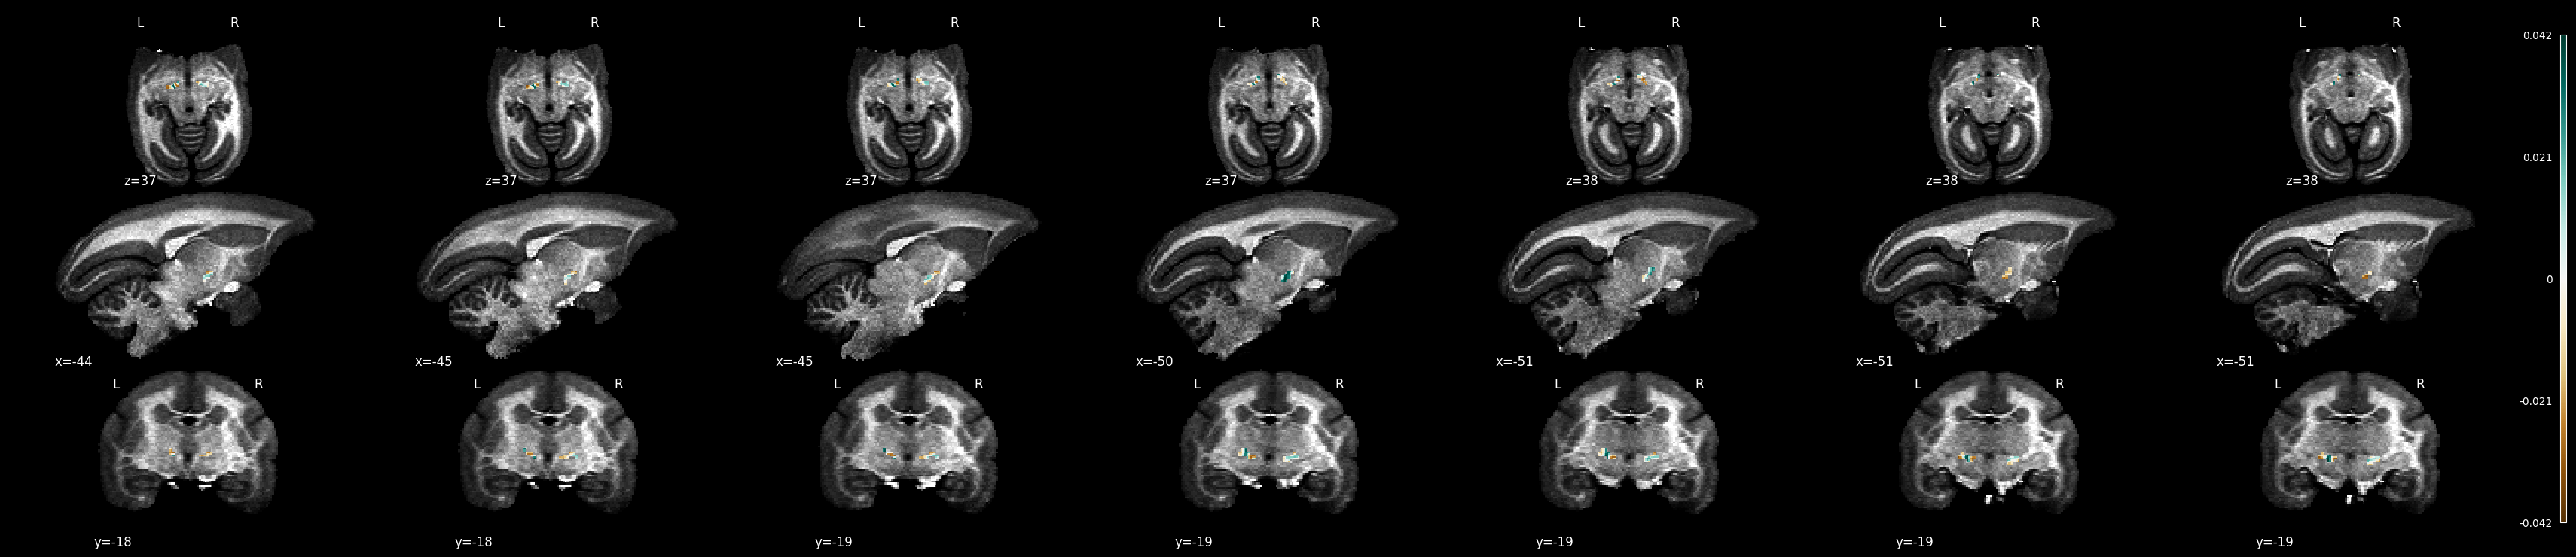

In [18]:
import nilearn

bg_img = '/home/ROBARTS/alik/graham/cfmm-bids/Khan/MarmZona_94T/derivatives/marm94T-preproc/results/sub-betty/anat/sub-betty_acq-mp2rage_desc-brain_T1w.nii.gz'

for gradi in range(6): # up to 6 gradients
    
    grad_img = results_path + f'Diff_gradient_{gradi+1}.nii.gz'
    color = matplotlib.colormaps[colors[gradi]]
    nilearn.plotting.plot_stat_map(grad_img,bg_img,cmap=color,dim=-1,display_mode='mosaic',
                                   colorbar=True,draw_cross=False)
    plt.savefig(fig_path + f'Diff_Gradient_{gradi+1}.png',dpi=300)

In [19]:
#visualize with brainspace/

### BF-gradient weighted cortical projection

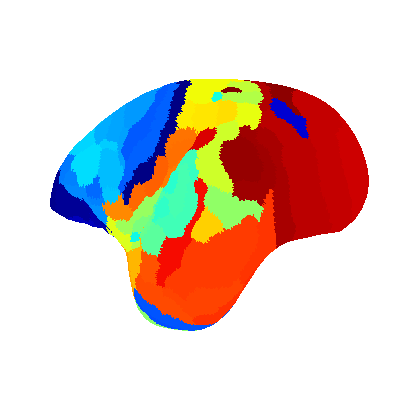

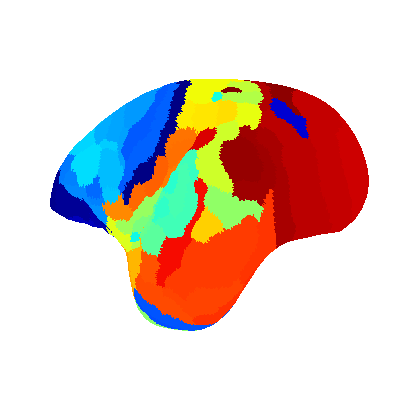

In [20]:
#load up cortical surface for MBMv3 template, which has Paxinos labelmap defined as well
from pathlib import Path

mbm_dir=Path('/home/ROBARTS/alik/graham/ext-data/marmosetbrainmapping_org/MBM_v3.0.1/')

label_gii=str(mbm_dir / 'surfFS.{hemi}.MBM_cortex_vPaxinos.label.gii')
surf_gii=str(mbm_dir / 'surfFS.{hemi}.pial.surf.gii')

nib_label = nib.load(label_gii.format(hemi='lh'))
paxinos_labels = nib_label.agg_data()

nib_surf = nib.load(surf_gii.format(hemi='lh'))
(coordinates,faces)=nib_surf.agg_data()

#following two commands are equivalent:
nilearn.plotting.plot_surf((coordinates,faces),surf_map=paxinos_labels,cmap='jet',avg_method='median')
#nilearn.plotting.plot_surf(surf_gii.format(hemi='lh'),label_gii.format(hemi='lh'),cmap='jet',avg_method='median')


(76068,)


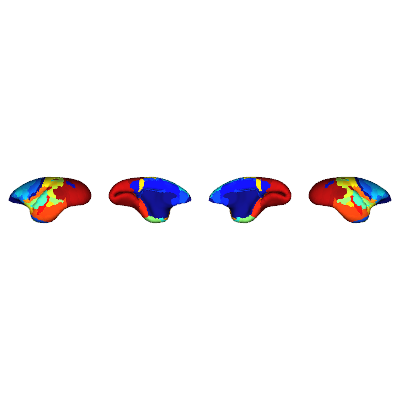

In [21]:
#do plotting with brainspace instead:
from brainspace.mesh.mesh_io import read_surface

surf_lh = read_surface(surf_gii.format(hemi='lh'))
surf_rh = read_surface(surf_gii.format(hemi='rh'))
paxinos_labels_arr = np.hstack([nib.load(label_gii.format(hemi=hemi)).agg_data() for hemi in ['lh','rh']])


print(paxinos_labels_arr.shape)|

plot_hemispheres(surf_lh,surf_rh,array_name=paxinos_labels_arr,embed_nb=True,cmap='jet')

In [23]:
# expand the corr_avg to match 360 cortical targets and get log-sclaed avgFC
#corr_avgFC = np.concatenate((corr_avg,corr_avg), axis=1)
corr_avgFC = corr
log_corr_avgFC = np.log(corr)

In [24]:
corr.shape

(648, 116)

In [25]:
# save the matrices
pd.DataFrame(corr_avgFC).to_csv(results_path + f'Diff_corr-avgFC.csv', index=False)
pd.DataFrame(log_corr_avgFC).to_csv(results_path + f'Diff_log-corr-avgFC.csv', index=False)

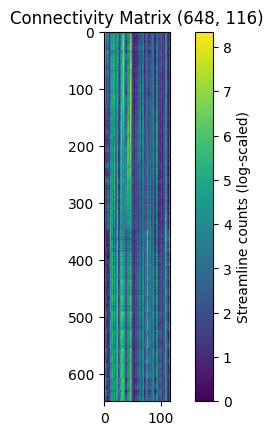

In [26]:
# Plot this matrix.
f, ax = plt.subplots(1,1,dpi=100)
im = ax.imshow(log_corr_avgFC)
ax.set_title('Connectivity Matrix {}'.format(corr_avgFC.shape))
cbar = plt.colorbar(im)
cbar.set_label("Streamline counts (log-scaled)")
plt.show()

In [27]:
# compute gradient weighted cortical maps for up to 6th gradients
G_Ctx = {}
for g in range(6):
    G_Ctx[g] = np.zeros(corr_avgFC.shape)
    for i in range(len(gm.gradients_[:,g])):
        G_Ctx[g][i,:] = log_corr_avgFC[i,:]*gm.gradients_[i,g]

In [28]:
np.savez(results_path + 'Diff_Gradient-weighted_CorticalConnectivity.npz', G1_Ctx=G_Ctx[0], G2_Ctx=G_Ctx[1], G3_Ctx=G_Ctx[2], G4_Ctx=G_Ctx[3], G5_Ctx=G_Ctx[4], G6_Ctx=G_Ctx[5])

In [29]:
Gfc = {}
for g in range(6):
    Gfc[g] = np.nanmean(G_Ctx[g], axis=0).reshape([corr.shape[1],1])

In [30]:
#instead of mapping to surface (since we don't have that at the moment)
# just remap the atlas labels to the gradient-weighted values
atlas_nii = '/home/ROBARTS/alik/graham/cfmm-bids/Khan/MarmZona_94T/derivatives/marm94T-preproc/results/sub-betty/anat/sub-betty_space-T1w_desc-paxinos_dseg.nii.gz'


atlas_nib = nib.load(atlas_nii)

lut_tsv = '/home/ROBARTS/alik/graham/cfmm-bids/Khan/MarmZona_94T/derivatives/subcorticalparc-smk/subcorticalparc_smk/resources/label-paxinos_dseg.tsv'
df_lut = pd.read_csv(lut_tsv,sep='\t')


In [31]:
df_lut

,label_num,name
0,1,A1_2
1,2,A10
2,3,A11
3,4,A13L
4,5,A13M
...,...,...
111,131,V4T
112,132,V5
113,133,V6
114,134,V6A


In [32]:


gwconn={}

for hemi in ['lh','rh']:
    surf_atlas = nib.load(label_gii.format(hemi=hemi)).agg_data()

    gwconn[hemi]={}
    for g in range(2):
        gwconn[hemi][g] = np.zeros(surf_atlas.shape)
        for i,labelnum in enumerate(df_lut.label_num):
            gwconn[hemi][g][surf_atlas == labelnum] =  Gfc[g][i]
    


In [33]:
colors

['seismic', 'Spectral', 'bwr', 'PRGn', 'coolwarm', 'BrBG']

In [38]:
#visualize the grad weighted conn map

for gradi in range(2): # up to 6 gradients
    color = matplotlib.colormaps[colors[gradi]]
    array_conn = np.hstack([ gwconn[hemi][gradi] for hemi in ['lh','rh']])
    fig_filename=fig_path + f'Diff_GradientWeightedConn_grad-{gradi+1}.png'
    plot_hemispheres(surf_lh,surf_rh,array_name=array_conn,size=(1000,1000),layout_style='grid',embed_nb=True,interactive=False,screenshot=True,filename=fig_filename,cmap=colors[gradi],color_bar=True)
    


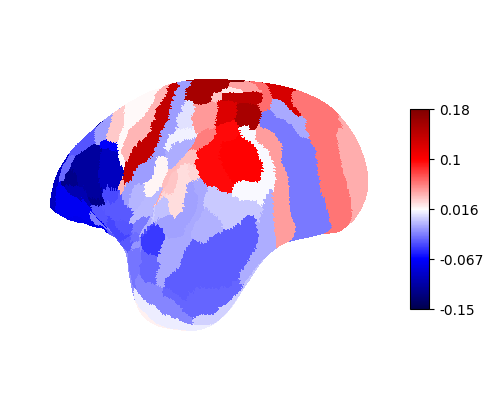

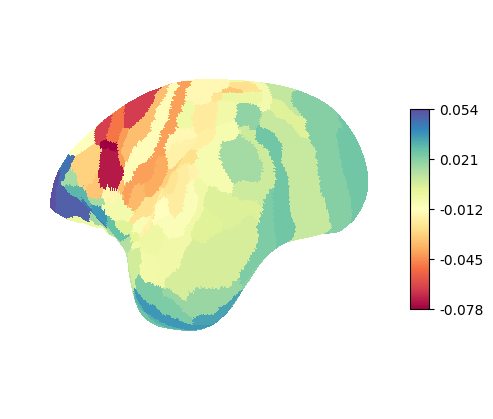

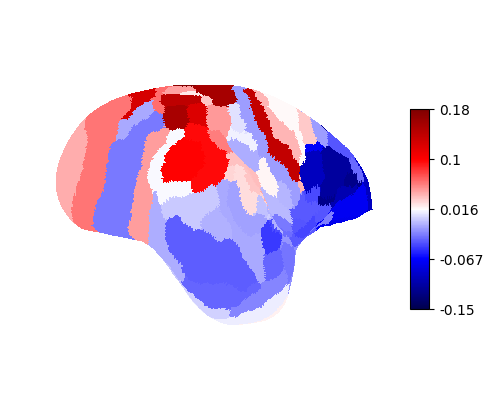

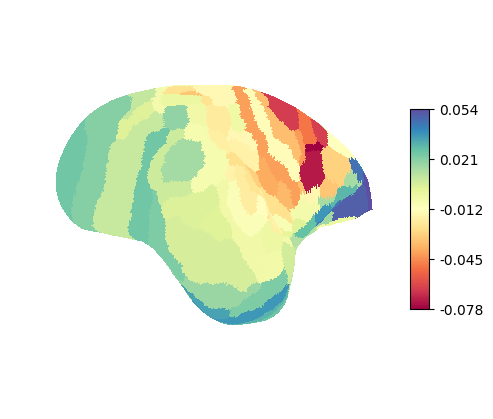

In [112]:
#visualize the grad weighted conn map using nilearn (poor quality visualization

hemi_from_abrev={'lh':'left','rh':'right'}

for hemi in ['lh','rh']:
    for gradi in range(2): # up to 6 gradients
    
        color = matplotlib.colormaps[colors[gradi]]
        nilearn.plotting.plot_surf(surf_gii.format(hemi=hemi),gwconn[hemi][gradi],hemi=hemi_from_abrev[hemi],cmap=color,avg_method='median',colorbar=True,alpha=0.8)
        plt.savefig(fig_path + f'Diff_GradientWeightedConn_hemi-{hemi}_grad-{gradi+1}.png',dpi=300)
    


In [111]:
#visualize the grad weighted conn map

for hemi in ['lh','rh']:
    for gradi in range(2): # up to 6 gradients
        
        color = matplotlib.colormaps[colors[gradi]]
        surf_view = nilearn.plotting.view_surf(surf_gii.format(hemi=hemi),gwconn[hemi][gradi],cmap=color,colorbar=True)
        
        surf_view.save_as_html(f'marm_hemi-{hemi}_grad-{gradi}_surf.html')
        
        
    


In [93]:
gwconn[0]

array([ 0.04263044,  0.04263044,  0.04263044, ..., -0.0965094 ,
       -0.0965094 , -0.0965094 ])

In [138]:
atlas_vol = atlas_nib.get_fdata()
gwconn={}
for g in range(2):
    gwconn_vol = np.zeros(atlas_vol.shape)
    for i,labelnum in enumerate(df_lut.label_num):
        gwconn_vol[atlas_vol == labelnum] =  Gfc[g][i]
        
    gwconn[g] = nib.Nifti1Image(gwconn_vol,
                                affine=atlas_nib.affine,
                                header=atlas_nib.header)


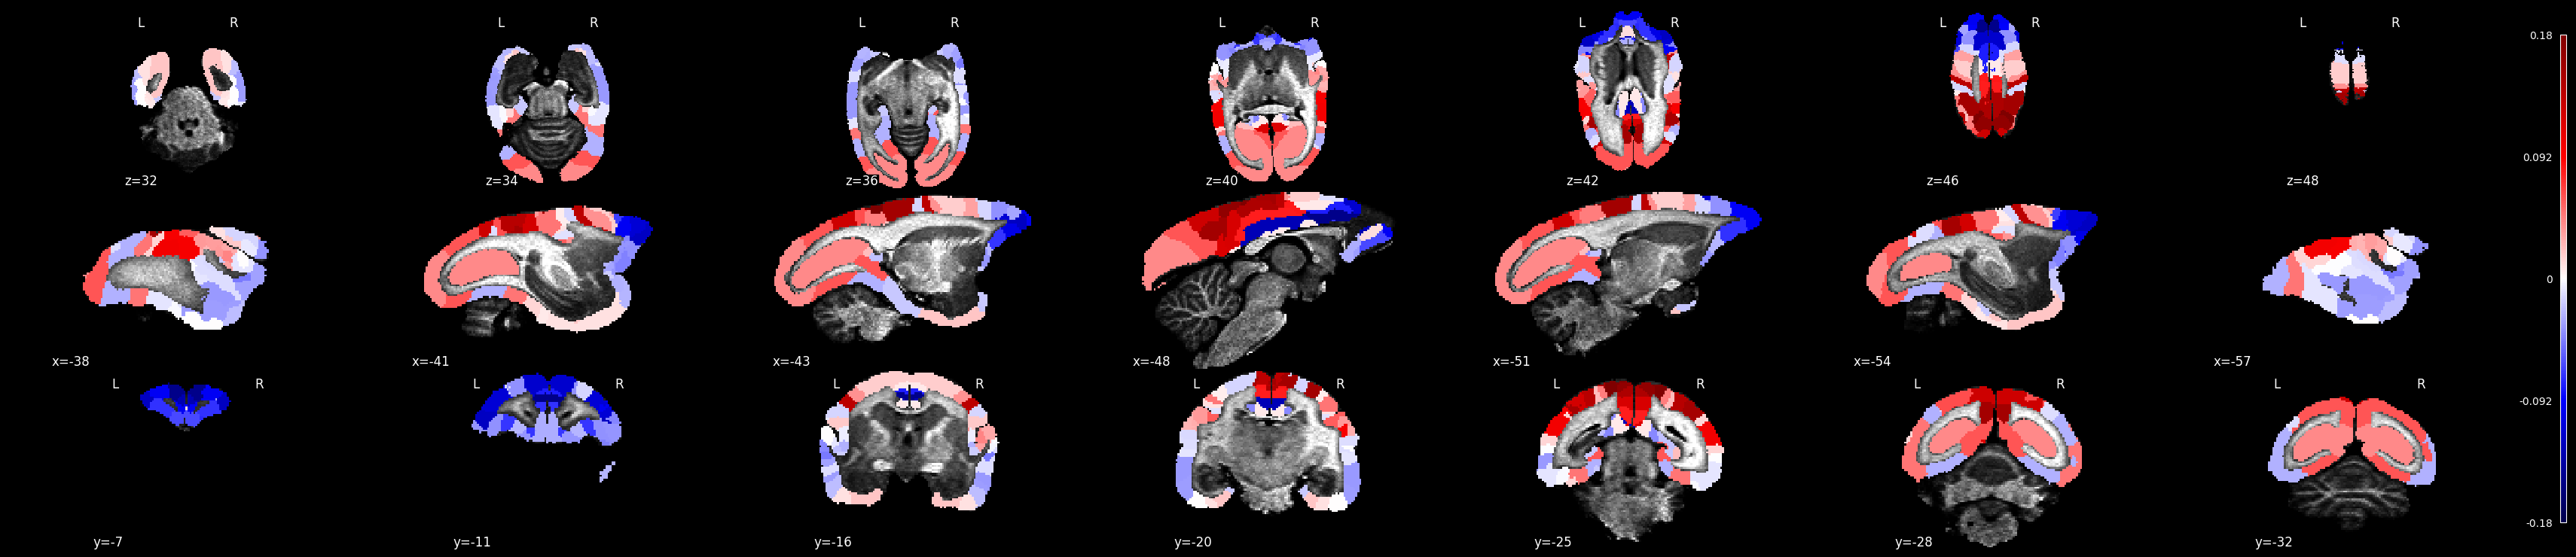

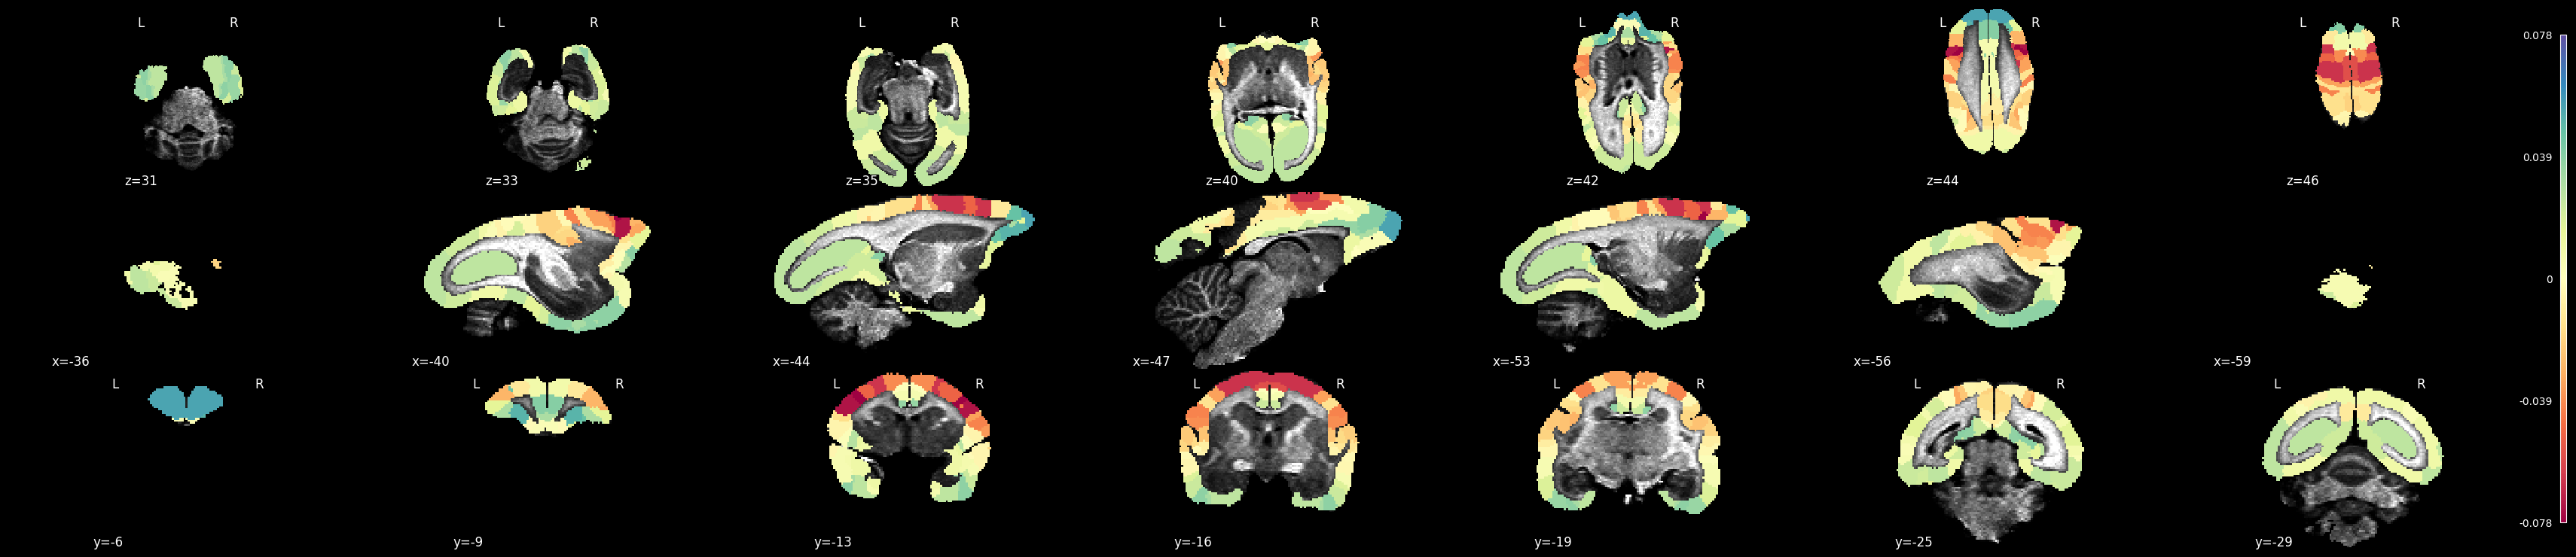

In [142]:
#visualize the grad weighted conn map
bg_img = '/home/ROBARTS/alik/graham/cfmm-bids/Khan/MarmZona_94T/derivatives/marm94T-preproc/results/sub-betty/anat/sub-betty_acq-mp2rage_desc-brain_T1w.nii.gz'

for gradi in range(2): # up to 6 gradients
    
    color = matplotlib.colormaps[colors[gradi]]
    nilearn.plotting.plot_stat_map(gwconn[gradi],bg_img,cmap=color,dim=-1,display_mode='mosaic',
                                   colorbar=True,draw_cross=False)
    plt.savefig(fig_path + f'Diff_GradientWeightedConn_{gradi+1}.png',dpi=300)